In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, accuracy_score, classification_report, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import os

seed = 1

In [158]:
FEATURES = [
    'MgFe', 
    '[M/H]_mean_mass', 
    '[M/H]_err_mass',
    'velDisp_ppxf_res', 
    'velDisp_ppxf_err_res',
    'age_mean_mass', 
    'age_err_mass', 
    'meanRad_r', 
    'logM*',
]

MODEL_PARAMS = {
    'max_depth': 22,
    'max_features': 0.793,
    'max_samples': 0.500,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 460,
    'random_state': 42
}

In [159]:
"""def evaluate_regression(df, n_splits=5):
    print(f"\nRunning {n_splits}-fold cross validation for regression...")
    
    X = df[FEATURES]
    y = df['DoR']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    
    scores = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        scores.append(r2)
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    print(f"\nMean R²: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return scores"""

def evaluate_final_regression(df, test_size=0.2):
    print("\nEvaluating final regression model...")
    
    X = df[FEATURES]
    y = df['DoR']
    
    # Split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions on test set
    y_test_pred = rf_model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Make predictions on all data
    X_all_scaled = scaler.transform(X)
    y_all_pred = rf_model.predict(X_all_scaled)
    all_r2 = r2_score(y, y_all_pred)
    
    # Plot test set predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y_test), min(y_test_pred))
    max_val = max(max(y_test), max(y_test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('True DoR')
    plt.ylabel('Predicted DoR')
    plt.title(f'Test Set Results\nR² = {test_r2:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot all data predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_all_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y), min(y_all_pred))
    max_val = max(max(y), max(y_all_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('True DoR')
    plt.ylabel('Predicted DoR')
    plt.title(f'All Data Results\nR² = {all_r2:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Test Set R²: {test_r2:.4f}")
    print(f"All Data R²: {all_r2:.4f}")
    
    return rf_model, scaler, test_r2, all_r2

In [160]:
def evaluate_classification(df, n_splits=5, split_threshold=0.6):
    """Run classification analysis with k-fold cross validation"""
    print(f"\nRunning {n_splits}-fold classification...")
    
    X = df[FEATURES]
    y = (df['DoR'] > split_threshold).astype(int)
    class_names = [f'DoR ≤ {split_threshold}', f'DoR > {split_threshold}']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    clf = RandomForestClassifier(**MODEL_PARAMS)
    
    results = {
        'accuracies': [], 'confusion_matrices': [],
        'classification_reports': [], 'roc_aucs': [], 'feature_importance':[]
    }
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
        
        # Store results
        results['accuracies'].append(accuracy_score(y_test, y_pred))
        results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        results['classification_reports'].append(
            classification_report(y_test, y_pred, target_names=class_names)
        )
        results['feature_importance'].append(
            dict(zip(FEATURES, clf.feature_importances_))
        )
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        results['roc_aucs'].append(auc(fpr, tpr))
        
        print(f"\nFold {fold}/{n_splits}")
        print(results['classification_reports'][-1])
    
    # Plot average confusion matrix
    avg_cm = np.mean(results['confusion_matrices'], axis=0) / (0.2 * len(df)) * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        avg_cm, annot=True, fmt='.1f', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Average Confusion Matrix Across All Folds')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    mean_importance = pd.DataFrame(results['feature_importance']).mean()
    plt.figure(figsize=(10, 6))
    mean_importance.sort_values().plot(kind='barh')
    plt.title('Mean Feature Importance Across All Folds')
    plt.xlabel('Mean Importance')
    plt.tight_layout()
    plt.show()
    
    return results

In [161]:
def export_dor_groups_using_trues(df, output_path, small_boundary=0.4, large_boundary=0.55, csv_name='DoR_Groups.csv' ):
    '''Export DoR groups to CSV'''
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [
        f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
        for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])
    ]
    
    # Create labels
    labels = pd.Series(1, index=df.index)  # middle group
    labels[df['DoR'] <= small_boundary] = 0  # small group
    labels[df['DoR'] >= large_boundary] = 2  # large group
    
    # Save results
    results_df = pd.DataFrame({'SDSS_ID': sdss_ids, 'Cluster': labels})
    filename = os.path.join(output_path, csv_name)
    results_df.to_csv(filename, index=False)
    
    print(f"Saved DoR groups to {filename}")
    print("Group sizes:")
    print(f"DoR <= {small_boundary}: {sum(labels == 0)}")
    print(f"{small_boundary} < DoR < {large_boundary}: {sum(labels == 1)}")
    print(f"DoR >= {large_boundary}: {sum(labels == 2)}")

In [162]:
# done properly by cutting predicted not true dor
def export_dor_groups(df, model, scaler, output_path, small_boundary=0.35, large_boundary=0.65, csv_name='DoR_Groups.csv'):
    import os
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [
        f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
        for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])
    ]
    
    # Get features and scale them
    X = df[FEATURES]
    X_scaled = scaler.transform(X)
    
    # Get predicted DoR values
    dor_pred = model.predict(X_scaled)
    
    # Create labels based on predicted DoR
    labels = pd.Series(1, index=df.index)  # middle group
    labels[dor_pred <= small_boundary] = 0  # small group
    labels[dor_pred >= large_boundary] = 2  # large group
    
    # Save results
    results_df = pd.DataFrame({
        'SDSS_ID': sdss_ids, 
        'Cluster': labels,
        'True_DoR': df['DoR'],
        'Predicted_DoR': dor_pred
    })
    
    filename = os.path.join(output_path, csv_name)
    results_df.to_csv(filename, index=False)
    
    print(f"Saved DoR groups to {filename}")
    print("Group sizes (based on predicted DoR):")
    print(f"Predicted DoR <= {small_boundary}: {sum(labels == 0)}")
    print(f"{small_boundary} < Predicted DoR < {large_boundary}: {sum(labels == 1)}")
    print(f"Predicted DoR >= {large_boundary}: {sum(labels == 2)}")
    
    # Optional: plot histogram of predicted vs true DoR
    plt.figure(figsize=(10, 6))
    plt.hist(df['DoR'], bins=20, alpha=0.5, label='True DoR')
    plt.hist(dor_pred, bins=20, alpha=0.5, label='Predicted DoR')
    plt.axvline(small_boundary, color='red', linestyle='--', label=f'Small boundary ({small_boundary})')
    plt.axvline(large_boundary, color='green', linestyle='--', label=f'Large boundary ({large_boundary})')
    plt.xlabel('DoR Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of True vs Predicted DoR Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results_df


Evaluating final regression model...


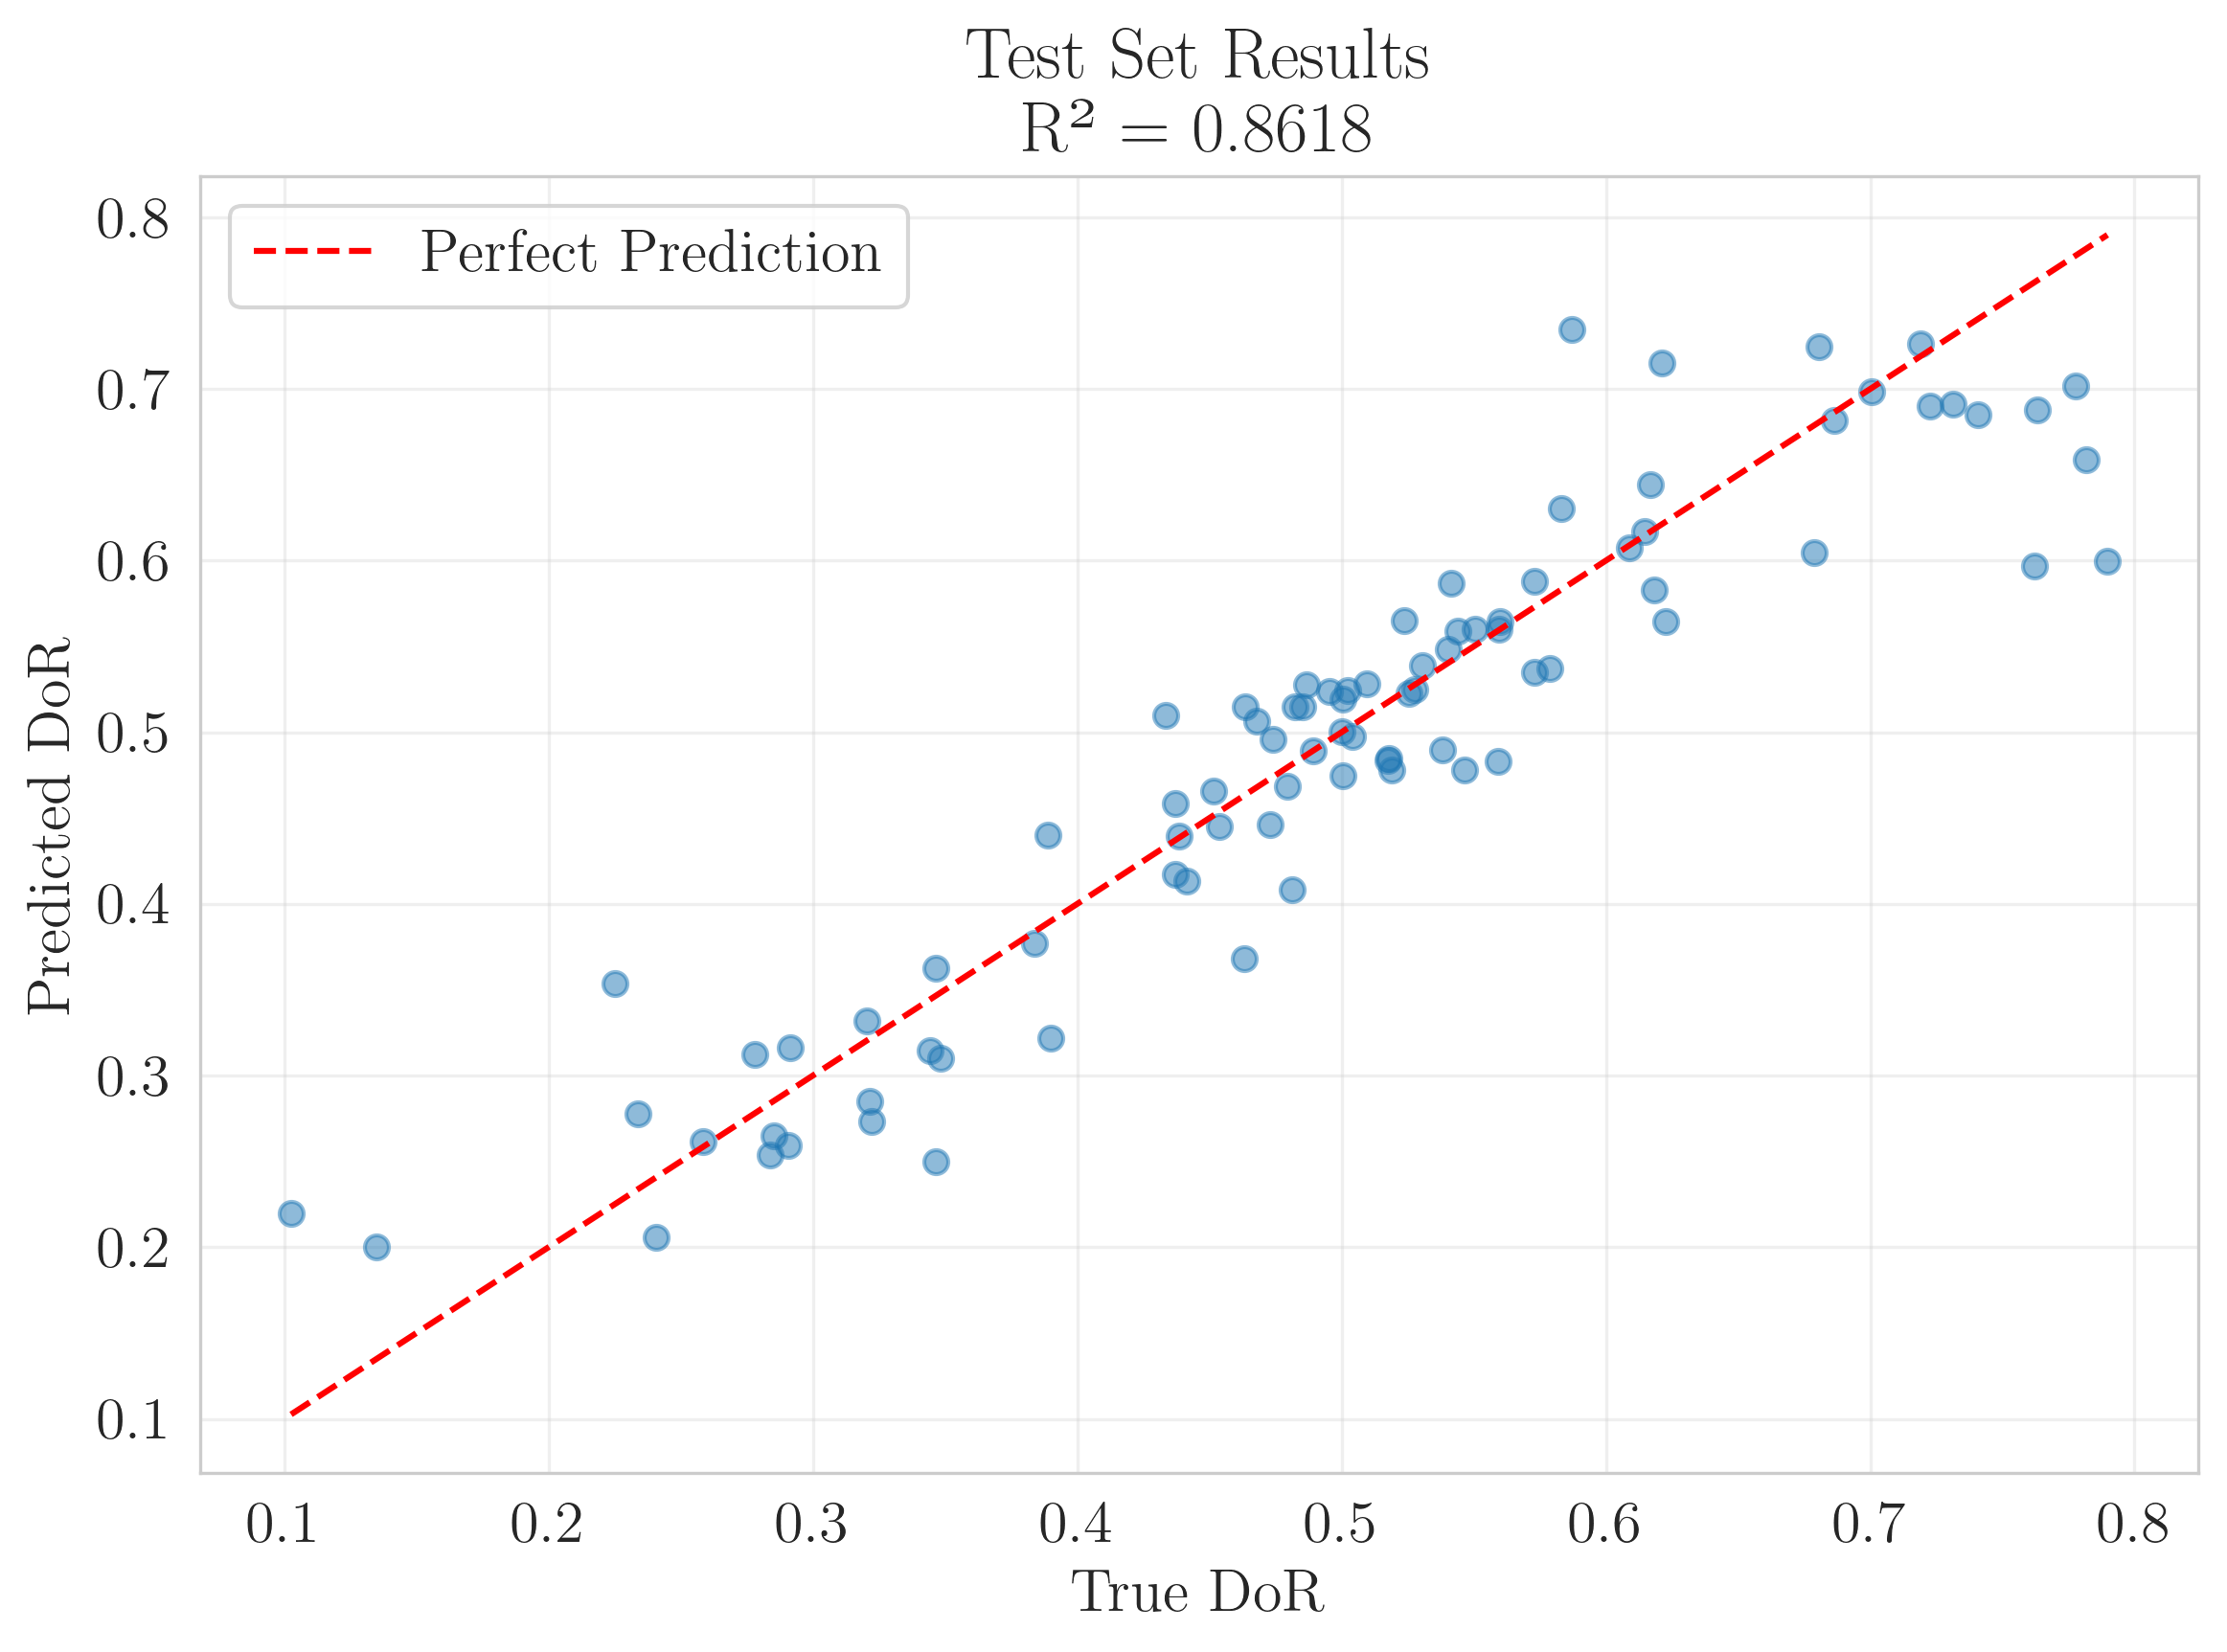

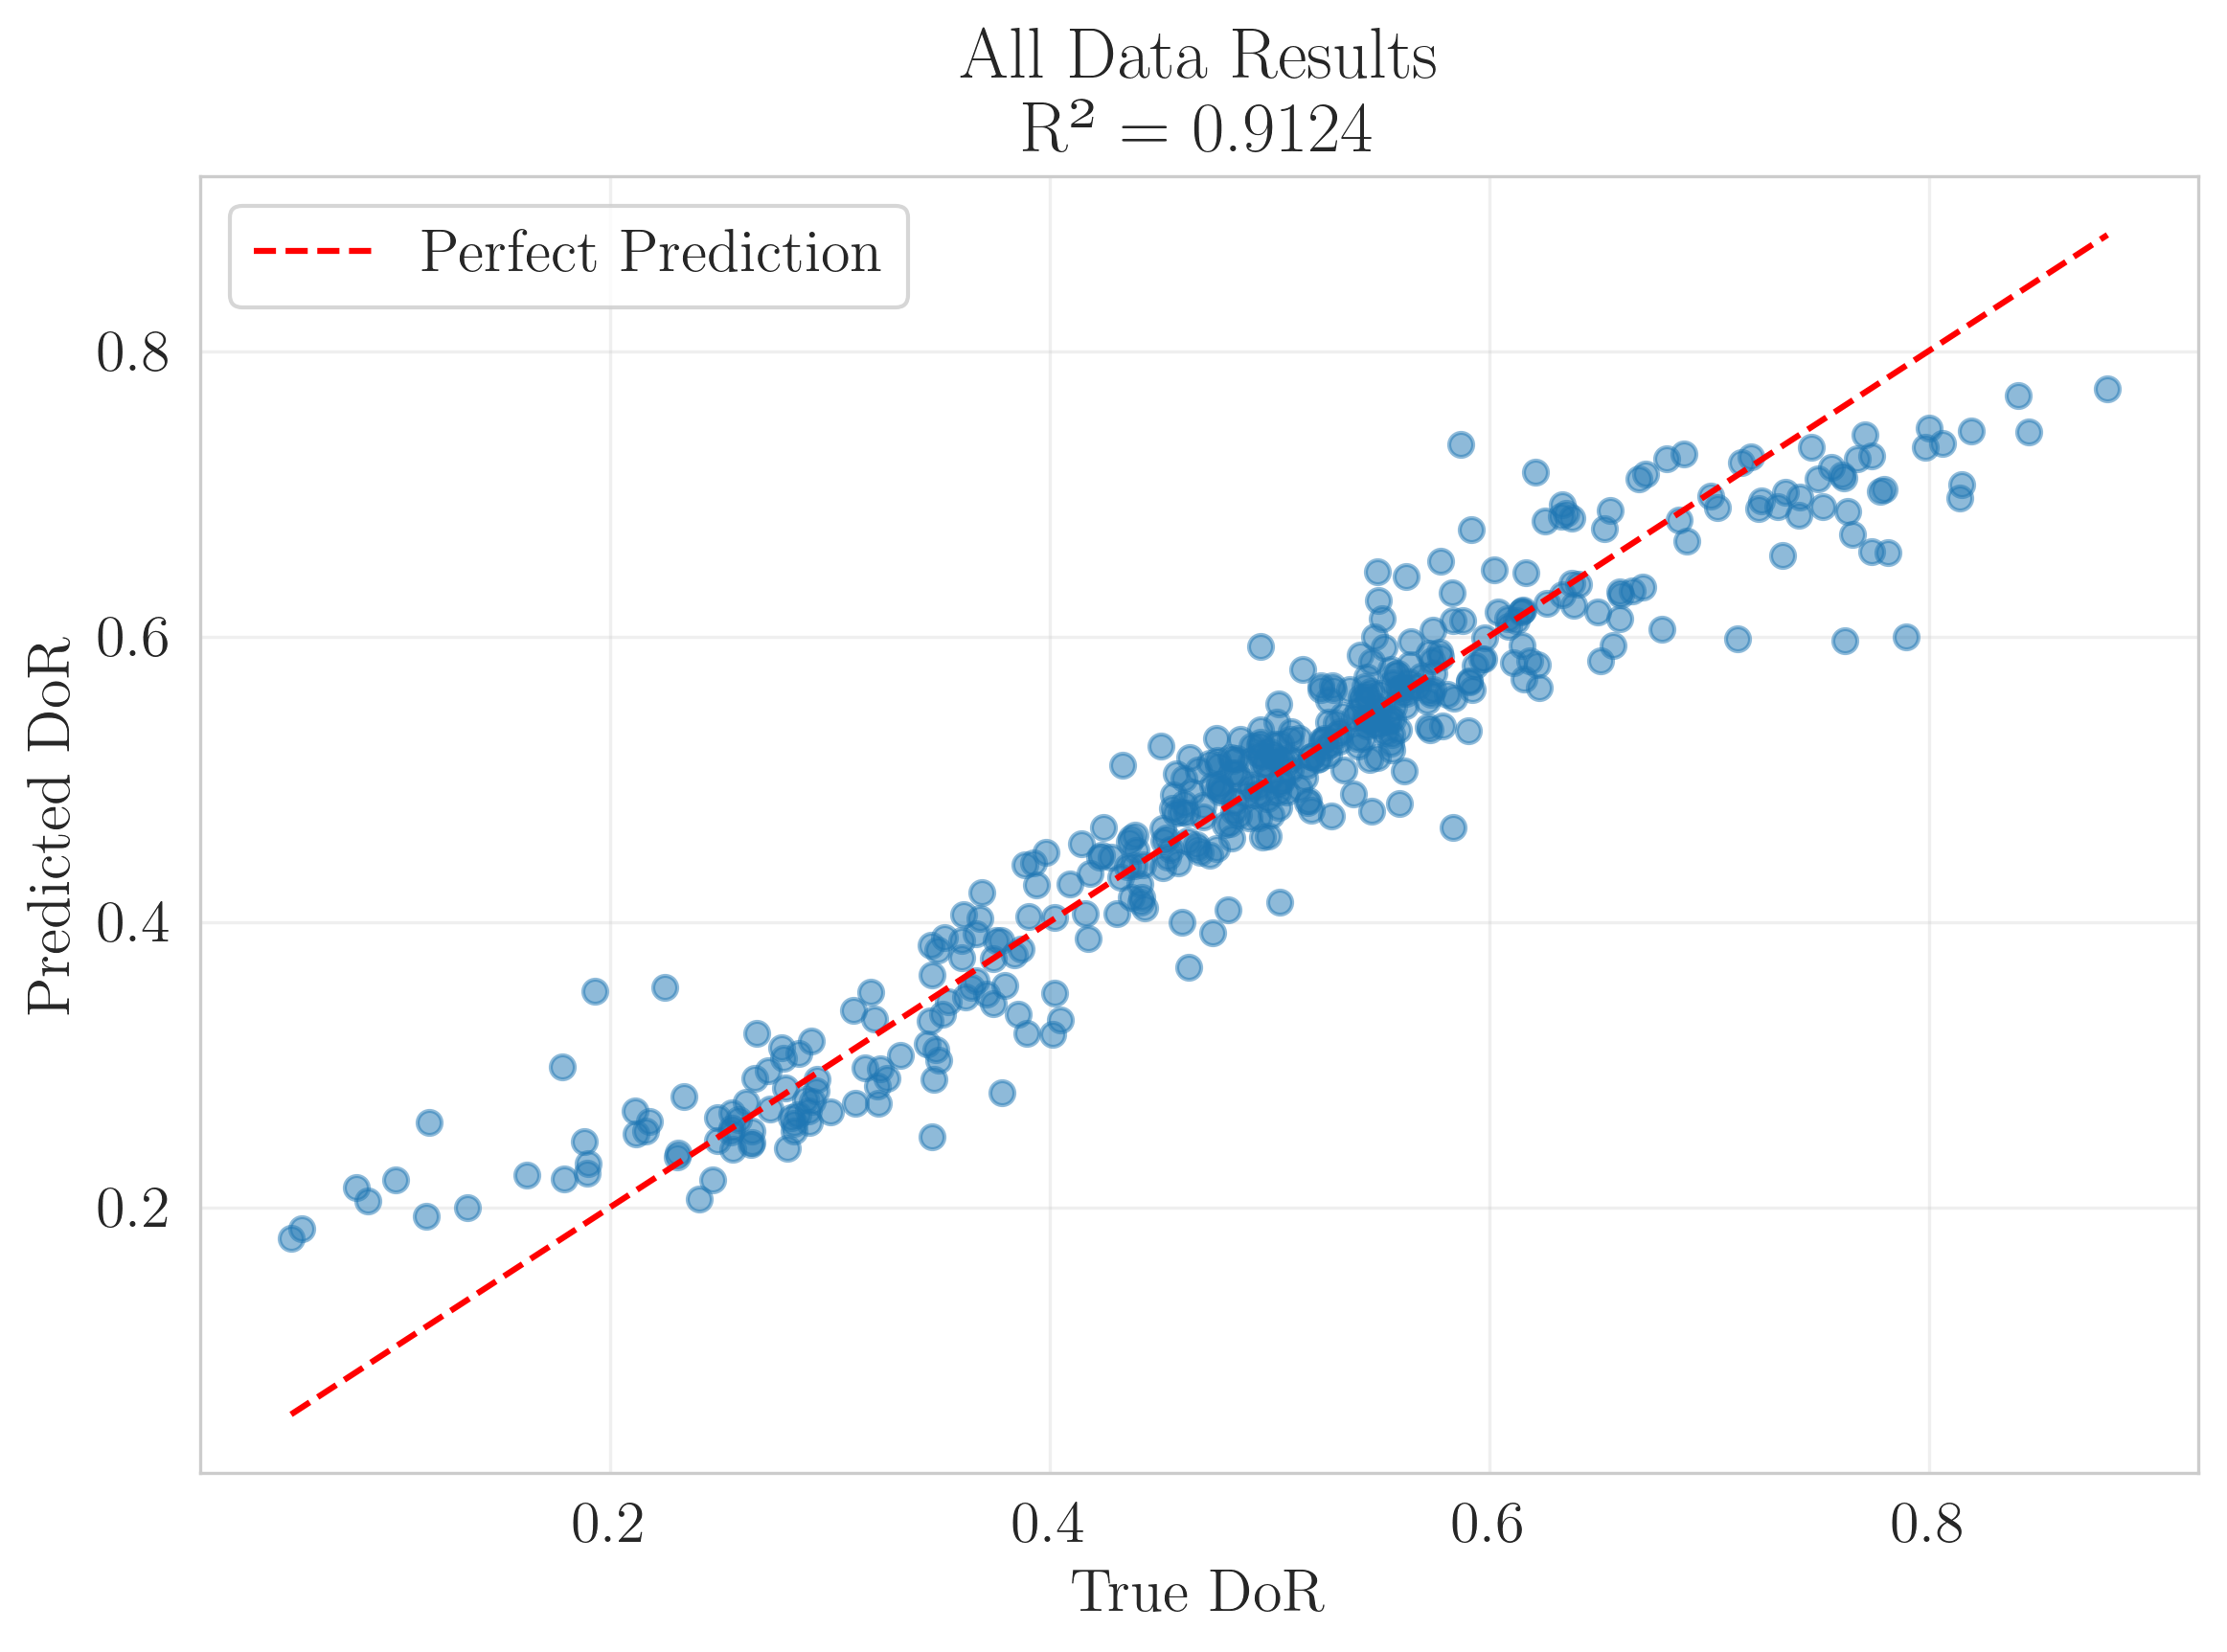

Test Set R²: 0.8618
All Data R²: 0.9124
Saved DoR groups to ../data/cluster_results/regression_clusters.csv
Group sizes (based on predicted DoR):
Predicted DoR <= 0.35: 80
0.35 < Predicted DoR < 0.65: 298
Predicted DoR >= 0.65: 52


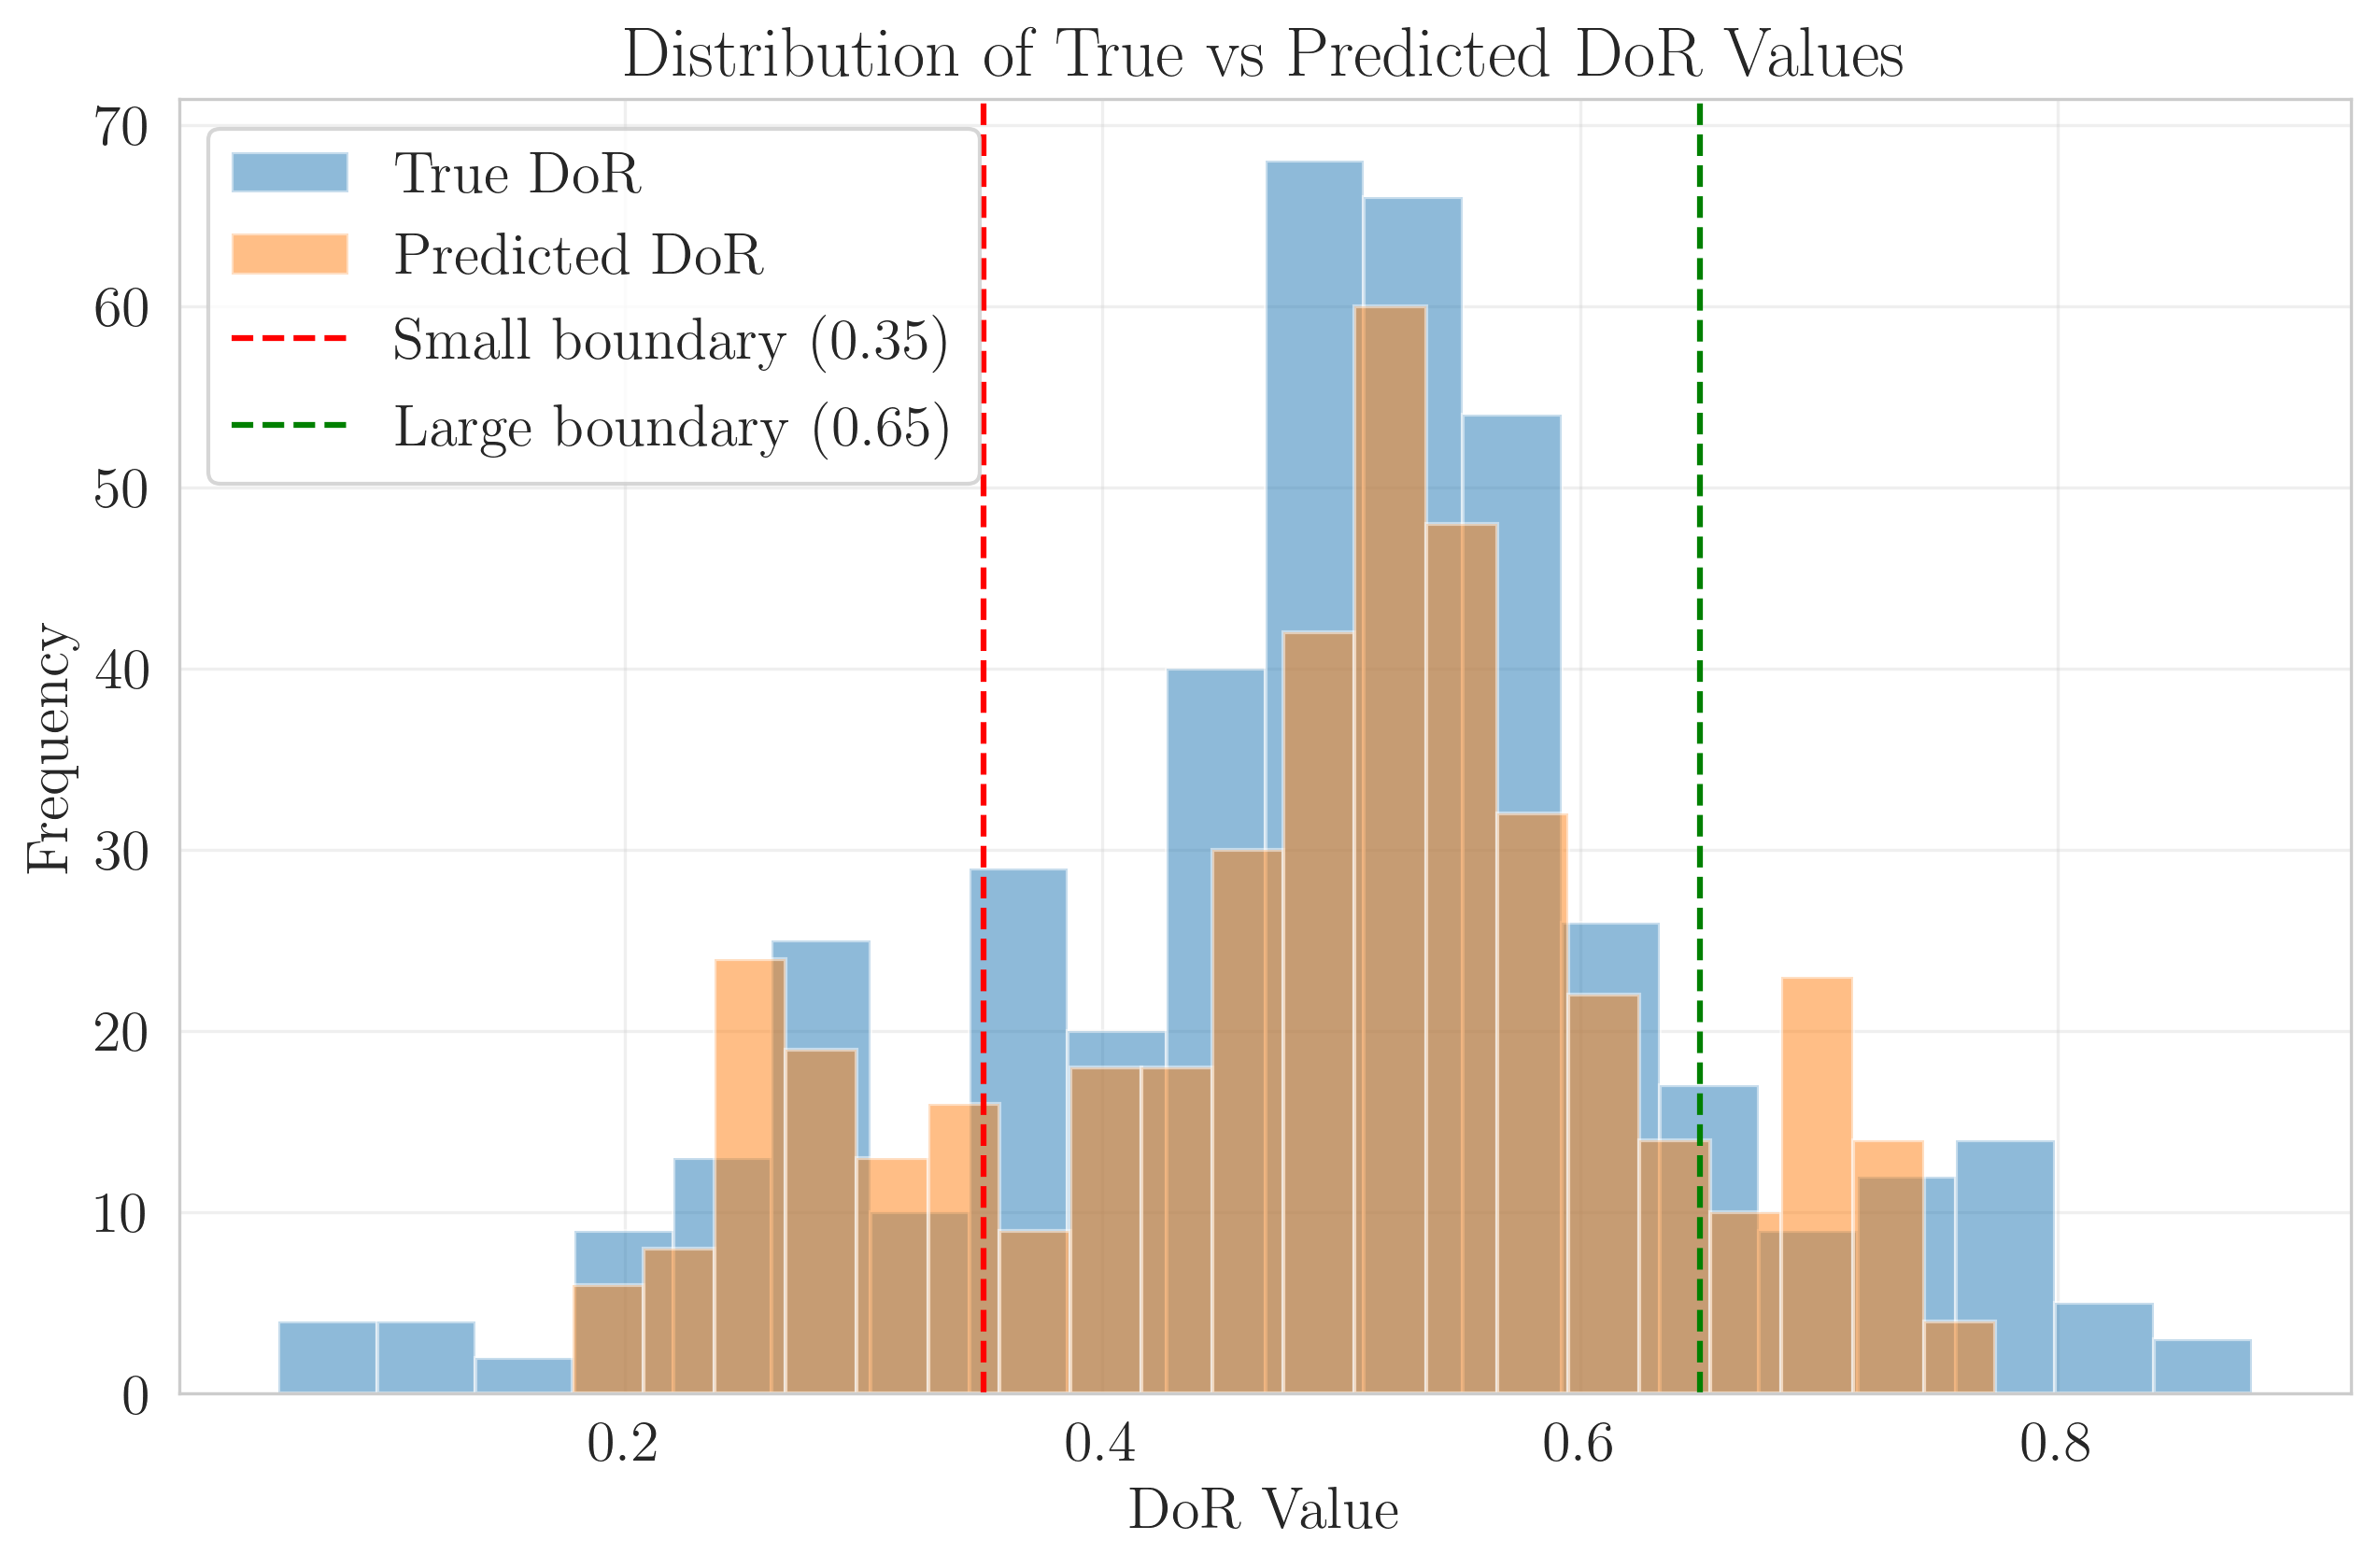

,SDSS_ID,Cluster,True_DoR,Predicted_DoR
0,spec-4405-55854-0591.fits,1,0.564630,0.596138
1,spec-1342-52793-0503.fits,1,0.529239,0.563106
2,spec-2775-54535-0128.fits,1,0.436232,0.456432
3,spec-0485-51909-0432.fits,1,0.486632,0.499592
4,spec-1781-53297-0341.fits,1,0.761979,0.596984
...,...,...,...,...
425,spec-2343-53735-0343.fits,0,0.255864,0.240690
426,spec-4842-55867-0080.fits,0,0.102624,0.219542
427,spec-2342-53742-0476.fits,1,0.509687,0.506145
428,spec-2150-54510-0524.fits,1,0.441544,0.413532


In [196]:
filepath = '../data/E-INSPIRE_I_master_catalogue.csv'
output_path = '../data/cluster_results'
csv_name = 'regression_clusters.csv'

df = pd.read_csv(filepath)
#df['velDisp_ppxf_res'] = np.log10(df['velDisp_ppxf_res'])
#df['velDisp_ppxf_err_res'] = np.log10(df['velDisp_ppxf_err_res'])


rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df)

export_dor_groups(
    df, 
    rf_model, 
    scaler, 
    small_boundary=0.35, 
    large_boundary=0.65, 
    output_path=output_path, 
    csv_name=csv_name
)

Fold 1/5 - R²: 0.8635, Mean uncertainty (±): 0.0638
Fold 2/5 - R²: 0.8183, Mean uncertainty (±): 0.0604
Fold 3/5 - R²: 0.8352, Mean uncertainty (±): 0.0588
Fold 4/5 - R²: 0.7995, Mean uncertainty (±): 0.0626
Fold 5/5 - R²: 0.8027, Mean uncertainty (±): 0.0601

Cross-validation results:
Mean fold R²: 0.8239 (±0.0235)
Overall R² (all predictions): 0.8239
95% CI coverage: 94.19%
Mean prediction interval width: 0.2396


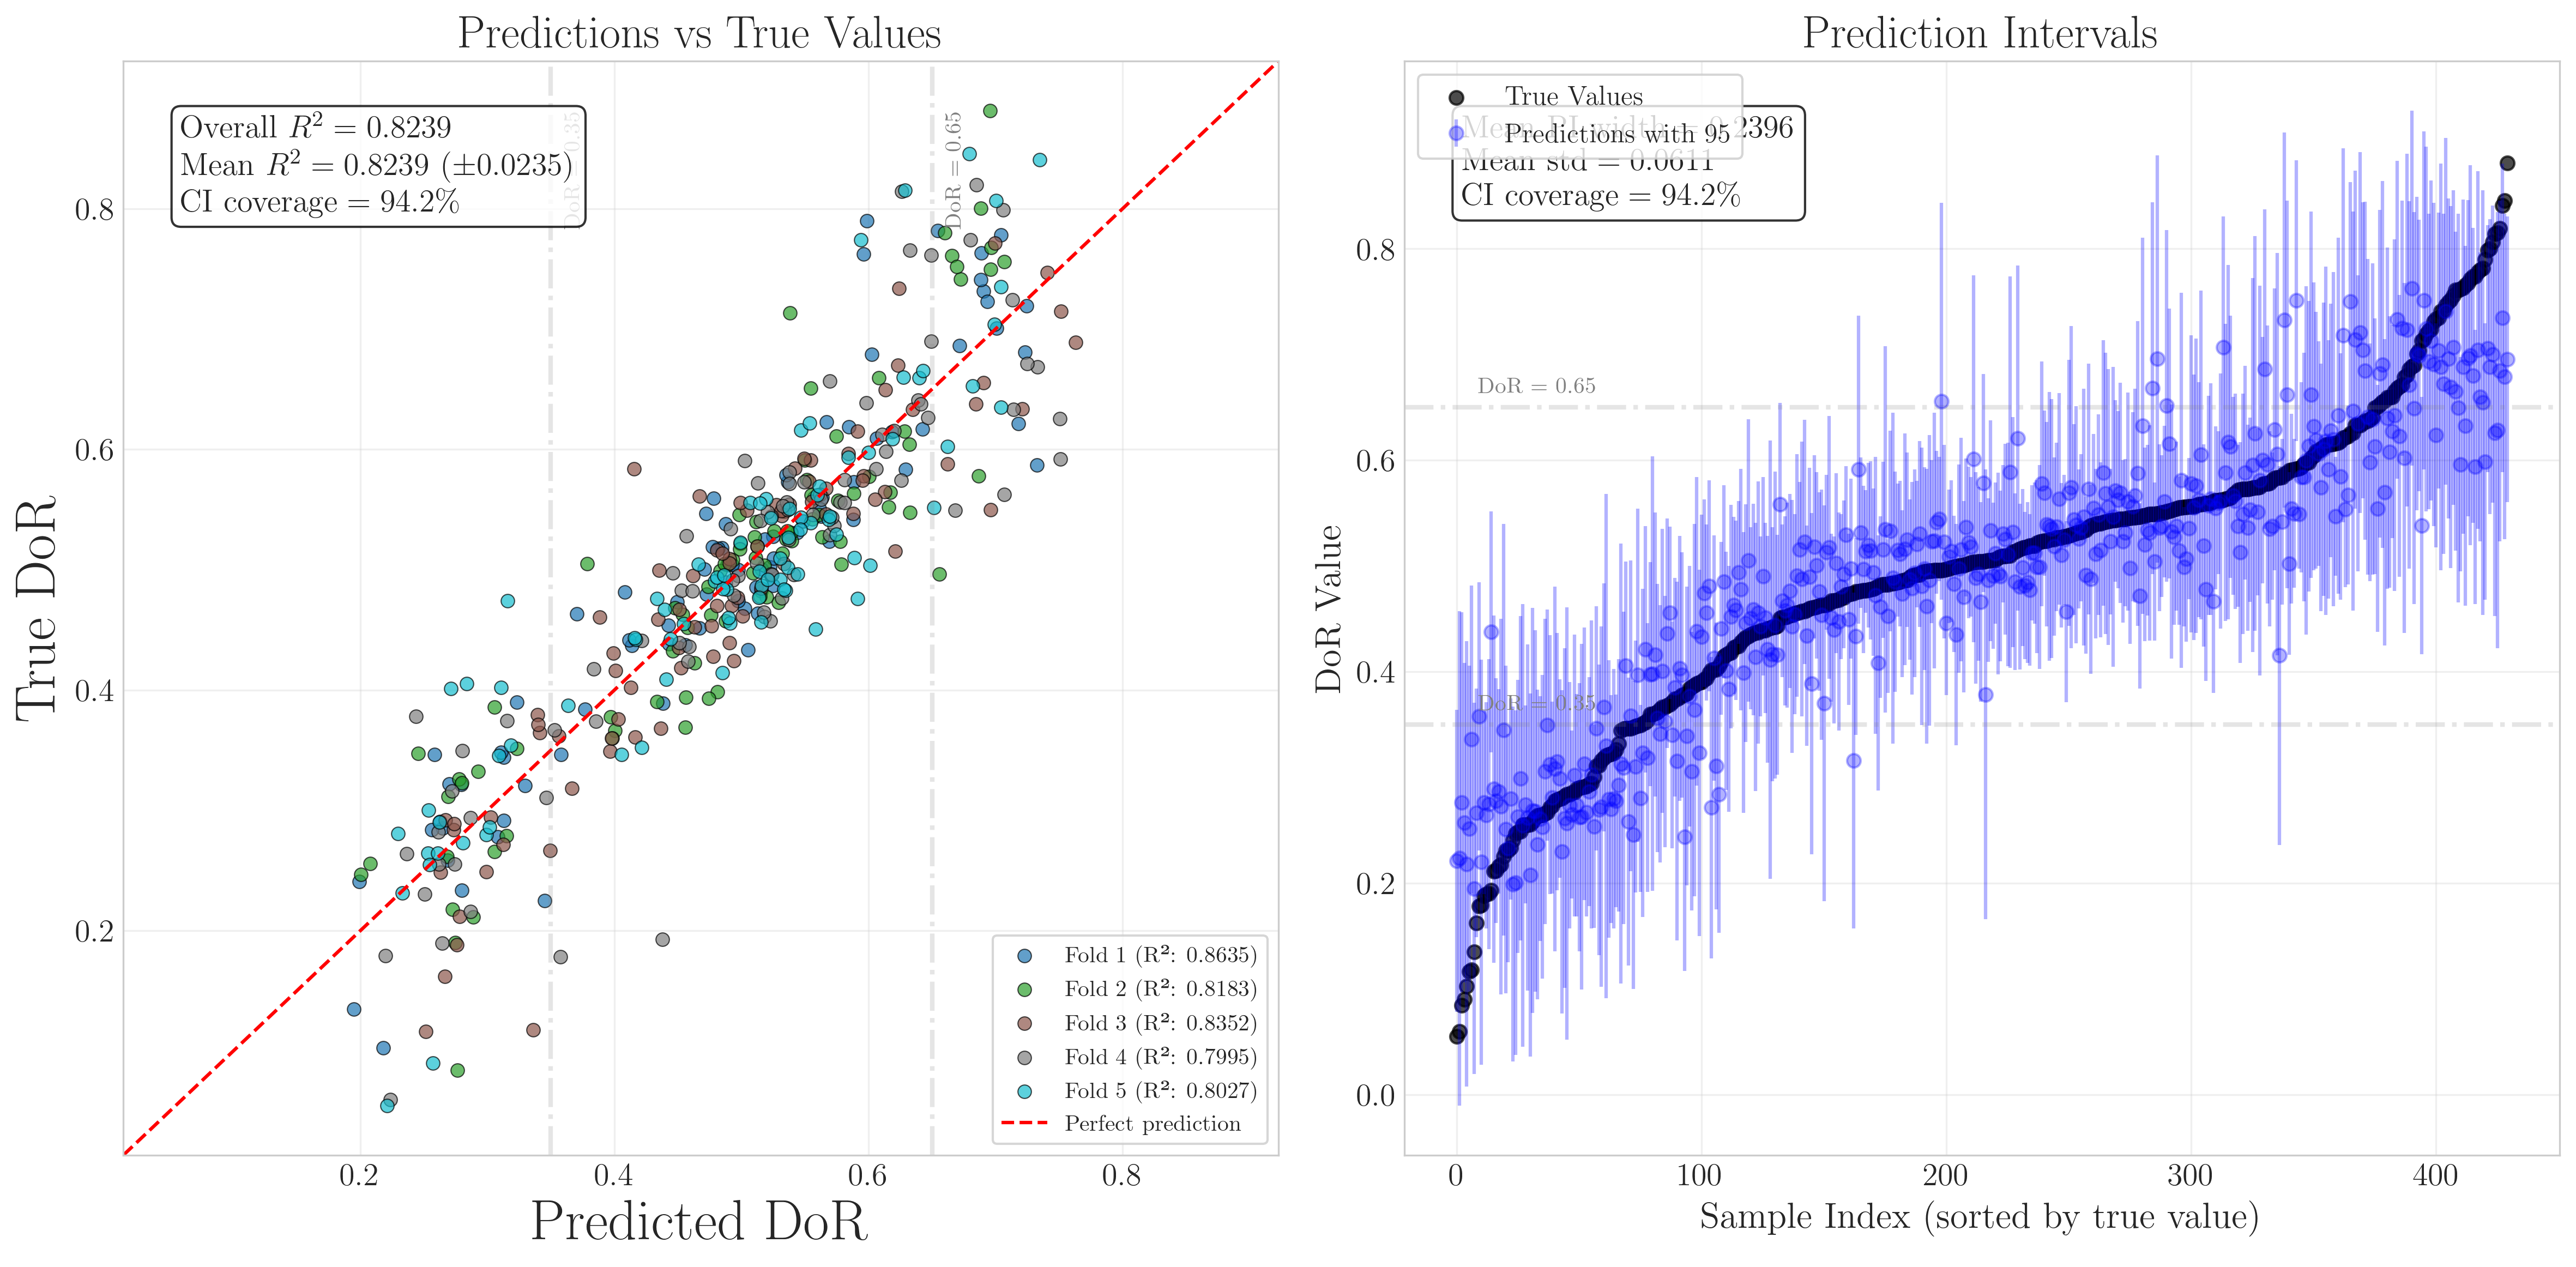

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import stats

def visualize_prob_kfold_predictions(df, features, target='DoR', n_splits=5, model_params=None, output_path=None):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Default model parameters if none provided
    if model_params is None:
        model_params = {
            'max_depth': 22,
            'max_features': 0.793,
            'max_samples': 0.500,
            'min_samples_leaf': 1,
            'min_samples_split': 4,
            'n_estimators': 460,
            'random_state': seed
        }
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initialize arrays to store all predictions
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    all_lower_ci = np.zeros_like(y)  # Lower confidence interval
    all_upper_ci = np.zeros_like(y)  # Upper confidence interval
    all_std = np.zeros_like(y)       # Standard deviation of predictions
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {'r2_scores': [], 'indices': [], 'predictions': [], 'lower_ci': [], 'upper_ci': [], 'std': []}
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        
        # Get predictions from all trees in the forest
        tree_predictions = np.array([tree.predict(X_test_scaled) for tree in rf_model.estimators_])
        
        # Calculate mean prediction (same as rf_model.predict)
        y_pred = np.mean(tree_predictions, axis=0)
        
        # Calculate standard deviation of predictions across trees
        y_std = np.std(tree_predictions, axis=0)
        
        # Calculate 95% confidence intervals
        # Option 1: Gaussian assumption
        y_lower = y_pred - 1.96 * y_std
        y_upper = y_pred + 1.96 * y_std
        
        # Option 2: Percentile-based (could use this instead)
        # y_lower = np.percentile(tree_predictions, 2.5, axis=0)
        # y_upper = np.percentile(tree_predictions, 97.5, axis=0)
        
        # Store results for this fold
        r2 = r2_score(y_test, y_pred)
        fold_results['r2_scores'].append(r2)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        fold_results['lower_ci'].append(y_lower)
        fold_results['upper_ci'].append(y_upper)
        fold_results['std'].append(y_std)
        
        # Store predictions at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        all_lower_ci[test_idx] = y_lower
        all_upper_ci[test_idx] = y_upper
        all_std[test_idx] = y_std
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}, Mean uncertainty (±): {np.mean(y_std):.4f}")
    
    # Calculate overall R² for all folds combined
    overall_r2 = r2_score(all_true, all_pred)
    mean_fold_r2 = np.mean(fold_results['r2_scores'])
    std_fold_r2 = np.std(fold_results['r2_scores'])
    
    # Calculate coverage (percentage of true values within confidence intervals)
    within_ci = (all_true >= all_lower_ci) & (all_true <= all_upper_ci)
    coverage = np.mean(within_ci) * 100
    
    # Calculate prediction interval width
    mean_pi_width = np.mean(all_upper_ci - all_lower_ci)
    
    print(f"\nCross-validation results:")
    print(f"Mean fold R²: {mean_fold_r2:.4f} (±{std_fold_r2:.4f})")
    print(f"Overall R² (all predictions): {overall_r2:.4f}")
    print(f"95% CI coverage: {coverage:.2f}%")
    print(f"Mean prediction interval width: {mean_pi_width:.4f}")

    # Create figure for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Predictions vs True values (as in your original code)
    # Plot each fold with different colors - SWAPPED AXES: x=predicted, y=true
    for fold in range(1, n_splits + 1):
        mask = fold_indices == fold
        ax1.scatter(all_pred[mask], all_true[mask], alpha=0.7, s=35, 
                   color=fold_colors[fold-1], edgecolors='k', linewidths=0.5,
                   label=f'Fold {fold} (R²: {fold_results["r2_scores"][fold-1]:.4f})')
    
    # Add perfect prediction line
    min_val = min(min(all_true), min(all_pred))
    max_val = max(max(all_true), max(all_pred))
    buffer = (max_val - min_val) * 0.05
    plot_min = min_val - buffer
    plot_max = max_val + buffer
    
    ax1.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', 
            label='Perfect prediction', linewidth=1.5)
    
    # Add vertical gray dash-dot lines at predicted DoR values of 0.35 and 0.65
    ax1.axvline(x=0.35, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax1.axvline(x=0.65, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    
    # Add small gray labels next to the lines (matching the style in the example)
    ax1.text(0.36, plot_max - buffer, 'DoR = 0.35', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    ax1.text(0.66, plot_max - buffer, 'DoR = 0.65', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    
    # Customize plot - SWAPPED AXES
    ax1.set_ylabel(f'True {target}', fontsize=25)
    ax1.set_xlabel(f'Predicted {target}', fontsize=25)
    ax1.set_ylim(plot_min, plot_max)
    ax1.set_xlim(plot_min, plot_max)
    
    # Add textbox with performance metrics
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{Overall}\ R^2 = %.4f$' % (overall_r2,),
        r'$\mathrm{Mean}\ R^2 = %.4f\ (\pm%.4f)$' % (mean_fold_r2, std_fold_r2),
        r'$\mathrm{CI\ coverage} = %.1f\%%$' % (coverage,)
    ))
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Add legend
    ax1.legend(loc='lower right', fontsize=10)
    
    # Add grid and styling
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax1.minorticks_on()
    ax1.set_title('Predictions vs True Values', fontsize=20)
    
    # Plot 2: Prediction Intervals
    # Sort data by true values for better visualization
    sort_idx = np.argsort(all_true)
    sorted_true = all_true[sort_idx]
    sorted_pred = all_pred[sort_idx]
    sorted_lower = all_lower_ci[sort_idx]
    sorted_upper = all_upper_ci[sort_idx]
    
    # Plot true values
    ax2.scatter(np.arange(len(sorted_true)), sorted_true, color='black', alpha=0.7, label='True Values')
    
    # Plot predictions with error bars
    ax2.errorbar(np.arange(len(sorted_pred)), sorted_pred, 
                yerr=[sorted_pred-sorted_lower, sorted_upper-sorted_pred],
                fmt='o', color='blue', alpha=0.3, label='Predictions with 95% CI')
    
    # Customize plot
    ax2.set_xlabel('Sample Index (sorted by true value)', fontsize=16)
    ax2.set_ylabel(f'{target} Value', fontsize=16)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
    
    # Highlight regions
    ax2.axhline(y=0.35, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax2.axhline(y=0.65, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax2.text(len(sorted_true)*0.02, 0.36, 'DoR = 0.35', 
            style='italic', color='gray', fontsize=10, va='bottom')
    ax2.text(len(sorted_true)*0.02, 0.66, 'DoR = 0.65', 
            style='italic', color='gray', fontsize=10, va='bottom')
    
    # Add textbox with uncertainty metrics
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{Mean\ PI\ width} = %.4f$' % (mean_pi_width,),
        r'$\mathrm{Mean\ std} = %.4f$' % (np.mean(all_std),),
        r'$\mathrm{CI\ coverage} = %.1f\%%$' % (coverage,)
    ))
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    ax2.set_title('Prediction Intervals', fontsize=20)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    return fig , fold_results

# Example usage (with your existing code):
fig, results = visualize_prob_kfold_predictions(
    df,  
    features=FEATURES,
    target='DoR',
    n_splits=5,
    model_params=MODEL_PARAMS,
    output_path='../outputs/prob_kfold_visualization.pdf'
)

Fold 1/5 - R²: 0.8635
Fold 2/5 - R²: 0.8183
Fold 3/5 - R²: 0.8352
Fold 4/5 - R²: 0.7995
Fold 5/5 - R²: 0.8027

Cross-validation results:
Mean fold R²: 0.8239 (±0.0235)
Overall R² (all predictions): 0.8239


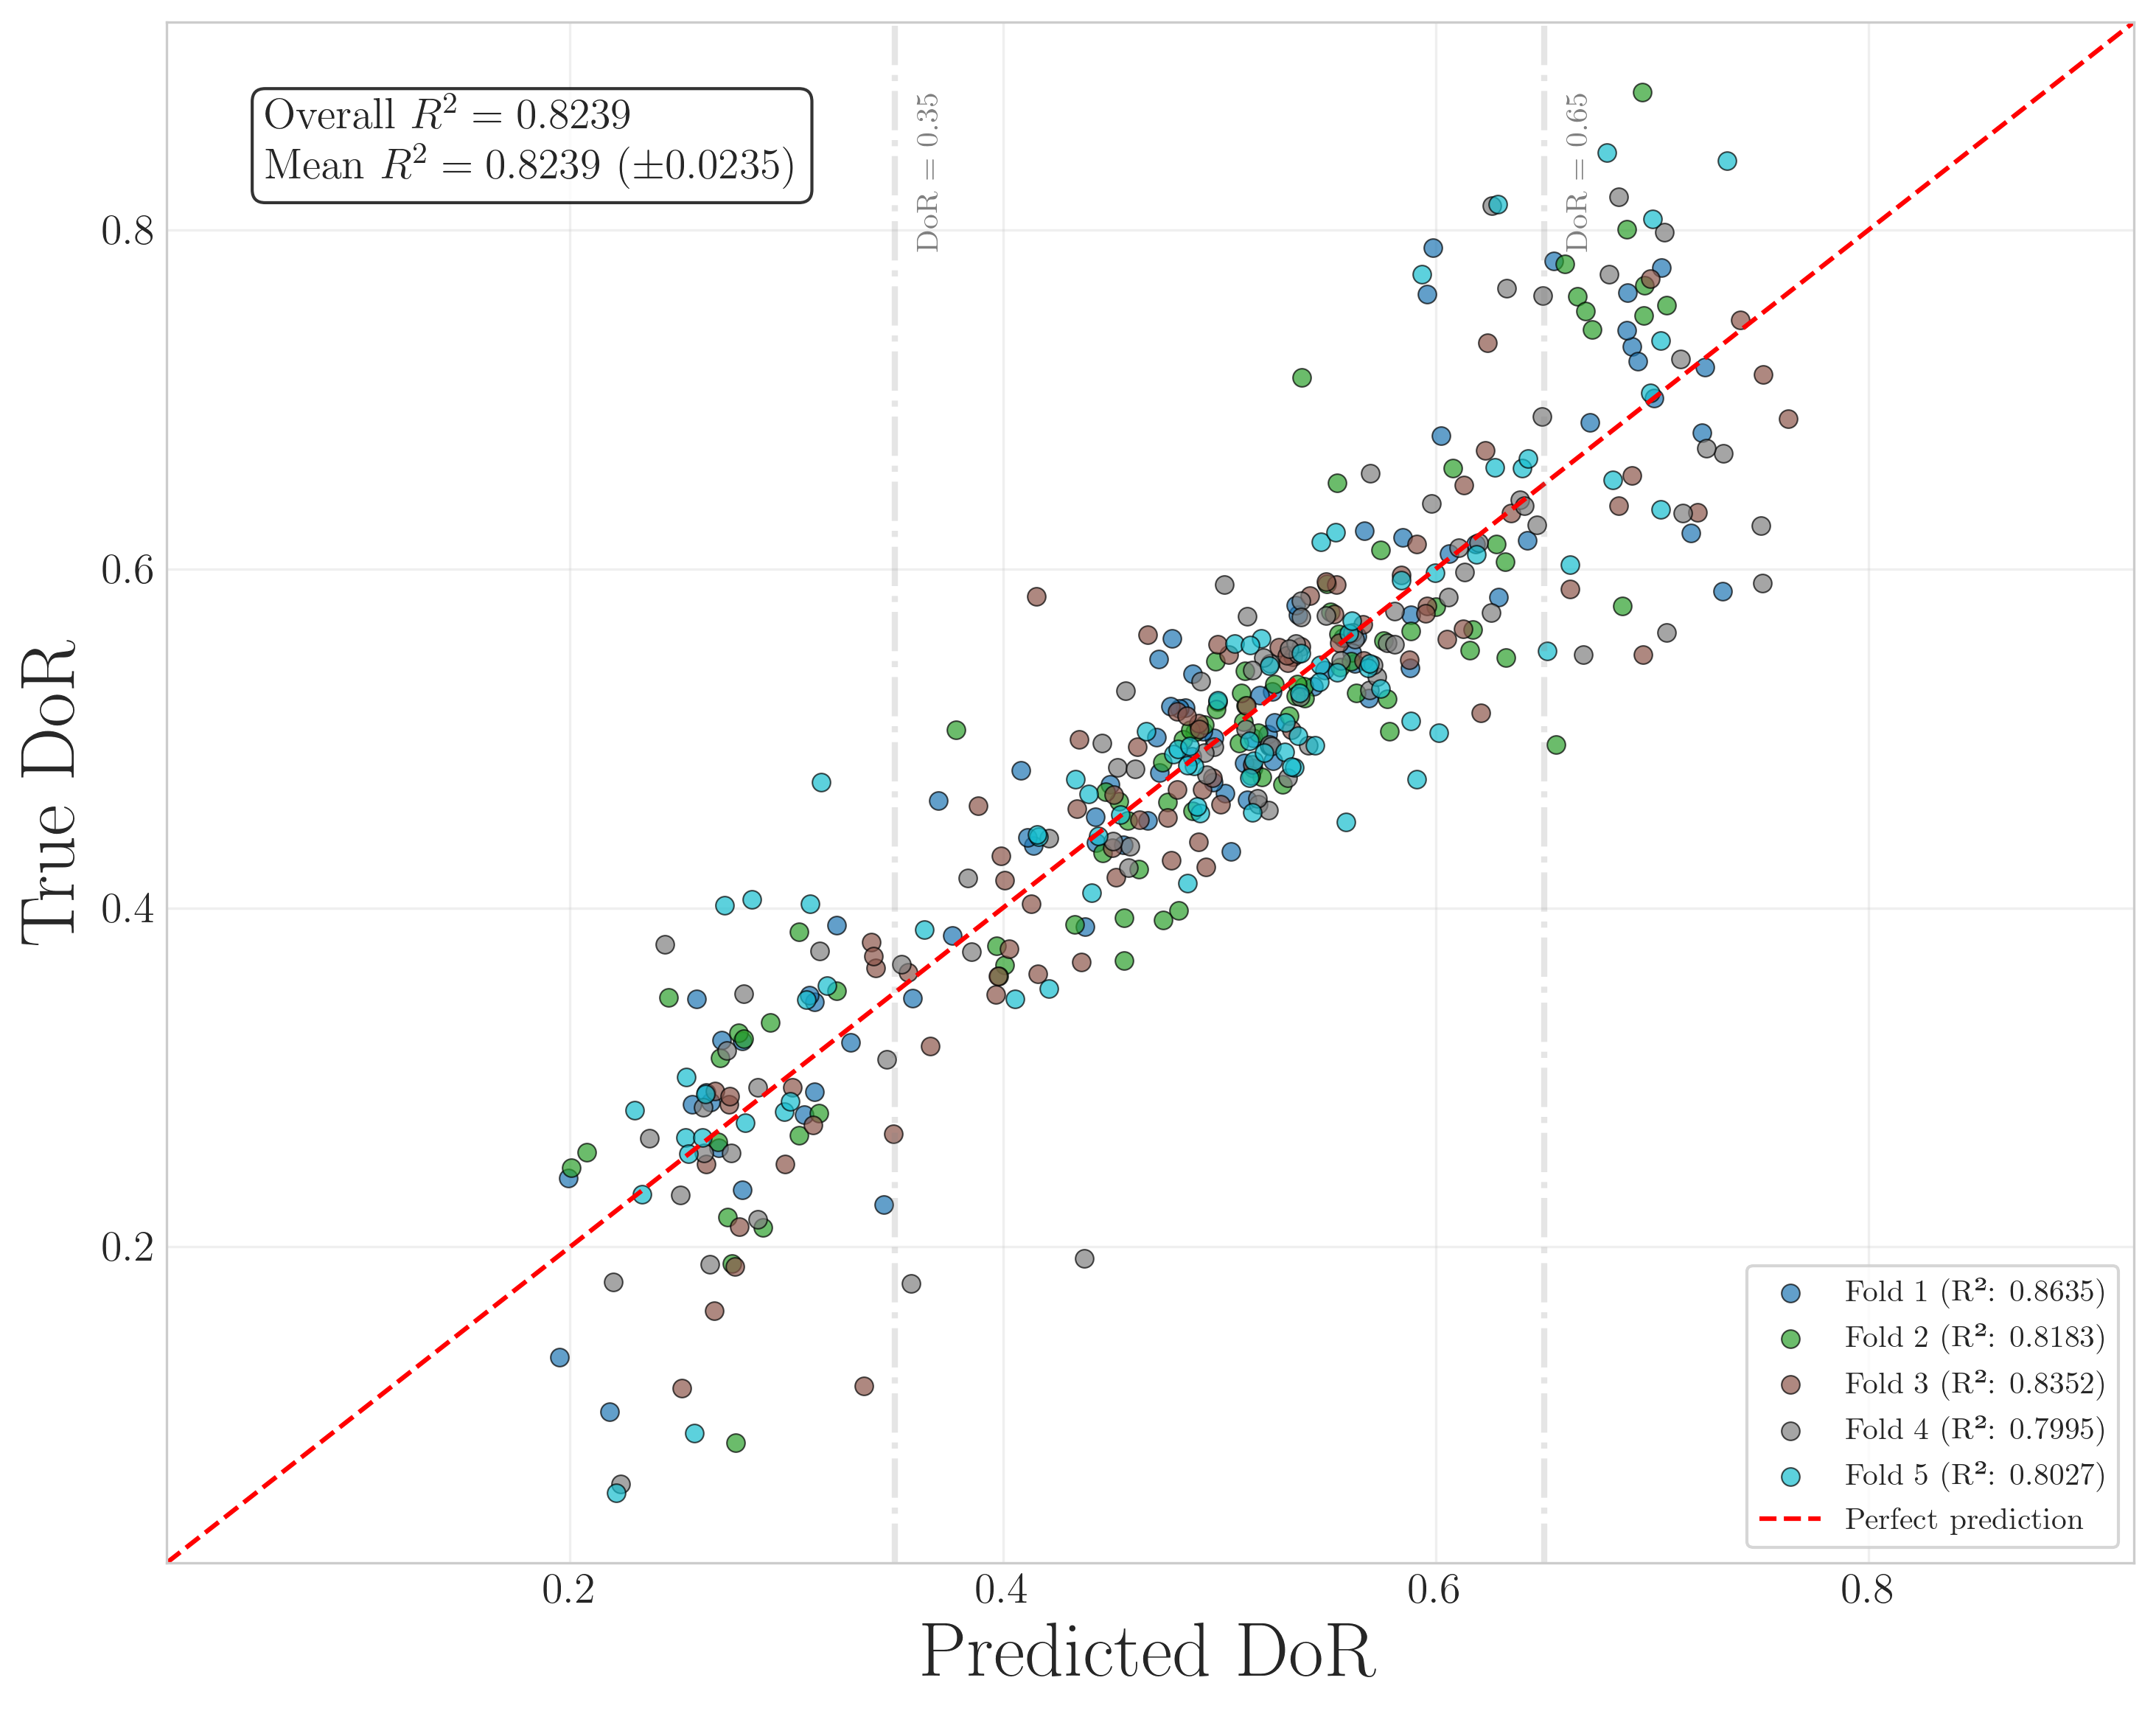

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# rotated version
def visualize_kfold_predictions(df, features, target='DoR', n_splits=5, model_params=None, output_path=None):
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Default model parameters if none provided
    if model_params is None:
        model_params = {
            'max_depth': 22,
            'max_features': 0.793,
            'max_samples': 0.500,
            'min_samples_leaf': 1,
            'min_samples_split': 4,
            'n_estimators': 460,
            'random_state': seed
        }
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initialize arrays to store all predictions
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {'r2_scores': [], 'indices': [], 'predictions': []}
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model and make predictions
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        
        # Store results for this fold
        r2 = r2_score(y_test, y_pred)
        fold_results['r2_scores'].append(r2)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        
        # Store predictions at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    # Calculate overall R² for all folds combined
    overall_r2 = r2_score(all_true, all_pred)
    mean_fold_r2 = np.mean(fold_results['r2_scores'])
    std_fold_r2 = np.std(fold_results['r2_scores'])
    
    print(f"\nCross-validation results:")
    print(f"Mean fold R²: {mean_fold_r2:.4f} (±{std_fold_r2:.4f})")
    print(f"Overall R² (all predictions): {overall_r2:.4f}")

    # Create figure for visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot each fold with different colors - SWAPPED AXES: x=predicted, y=true
    for fold in range(1, n_splits + 1):
        mask = fold_indices == fold
        ax.scatter(all_pred[mask], all_true[mask], alpha=0.7, s=35, 
                   color=fold_colors[fold-1], edgecolors='k', linewidths=0.5,
                   label=f'Fold {fold} (R²: {fold_results["r2_scores"][fold-1]:.4f})')
    
    # Add perfect prediction line
    min_val = min(min(all_true), min(all_pred))
    max_val = max(max(all_true), max(all_pred))
    buffer = (max_val - min_val) * 0.05
    plot_min = min_val - buffer
    plot_max = max_val + buffer
    
    ax.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', 
            label='Perfect prediction', linewidth=1.5)
    
    # Add vertical gray dash-dot lines at predicted DoR values of 0.35 and 0.65
    ax.axvline(x=0.35, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    ax.axvline(x=0.65, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    
    # Add small gray labels next to the lines (matching the style in the example)
    ax.text(0.36, plot_max - buffer, 'DoR = 0.35', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    ax.text(0.66, plot_max - buffer, 'DoR = 0.65', 
            style='italic', color='gray', fontsize=10, va='top', rotation=90)
    
    # Customize plot - SWAPPED AXES
    ax.set_ylabel(f'True {target}', fontsize=25)
    ax.set_xlabel(f'Predicted {target}', fontsize=25)
    ax.set_ylim(plot_min, plot_max)
    ax.set_xlim(plot_min, plot_max)
    
    # Add textbox with performance metrics
    props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{Overall}\ R^2 = %.4f$' % (overall_r2,),
        r'$\mathrm{Mean}\ R^2 = %.4f\ (\pm%.4f)$' % (mean_fold_r2, std_fold_r2),
        #r'$\mathrm{N\ folds} = %d$' % (n_splits,)
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Add legend
    ax.legend(loc='lower right', fontsize=10)
    
    # Add grid and styling
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax.minorticks_on()
    
    #plt.title(f'{n_splits}-Fold Cross-Validation Results', fontsize=18)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    return fig, fold_results

fig, results = visualize_kfold_predictions(
    df,  
    features=FEATURES,
    target='DoR',
    n_splits=5,
    model_params=MODEL_PARAMS,
    output_path='../outputs/kfold_visualization.pdf'
)

Fold 1/5 - R²: 0.8089, MAE: 0.0523, RMSE: 0.0710
Fold 2/5 - R²: 0.7912, MAE: 0.0461, RMSE: 0.0649
Fold 3/5 - R²: 0.8167, MAE: 0.0486, RMSE: 0.0647
Fold 4/5 - R²: 0.8136, MAE: 0.0481, RMSE: 0.0657
Fold 5/5 - R²: 0.8320, MAE: 0.0418, RMSE: 0.0564

Overall metrics:
R²: 0.8123, MAE: 0.0474, RMSE: 0.0647


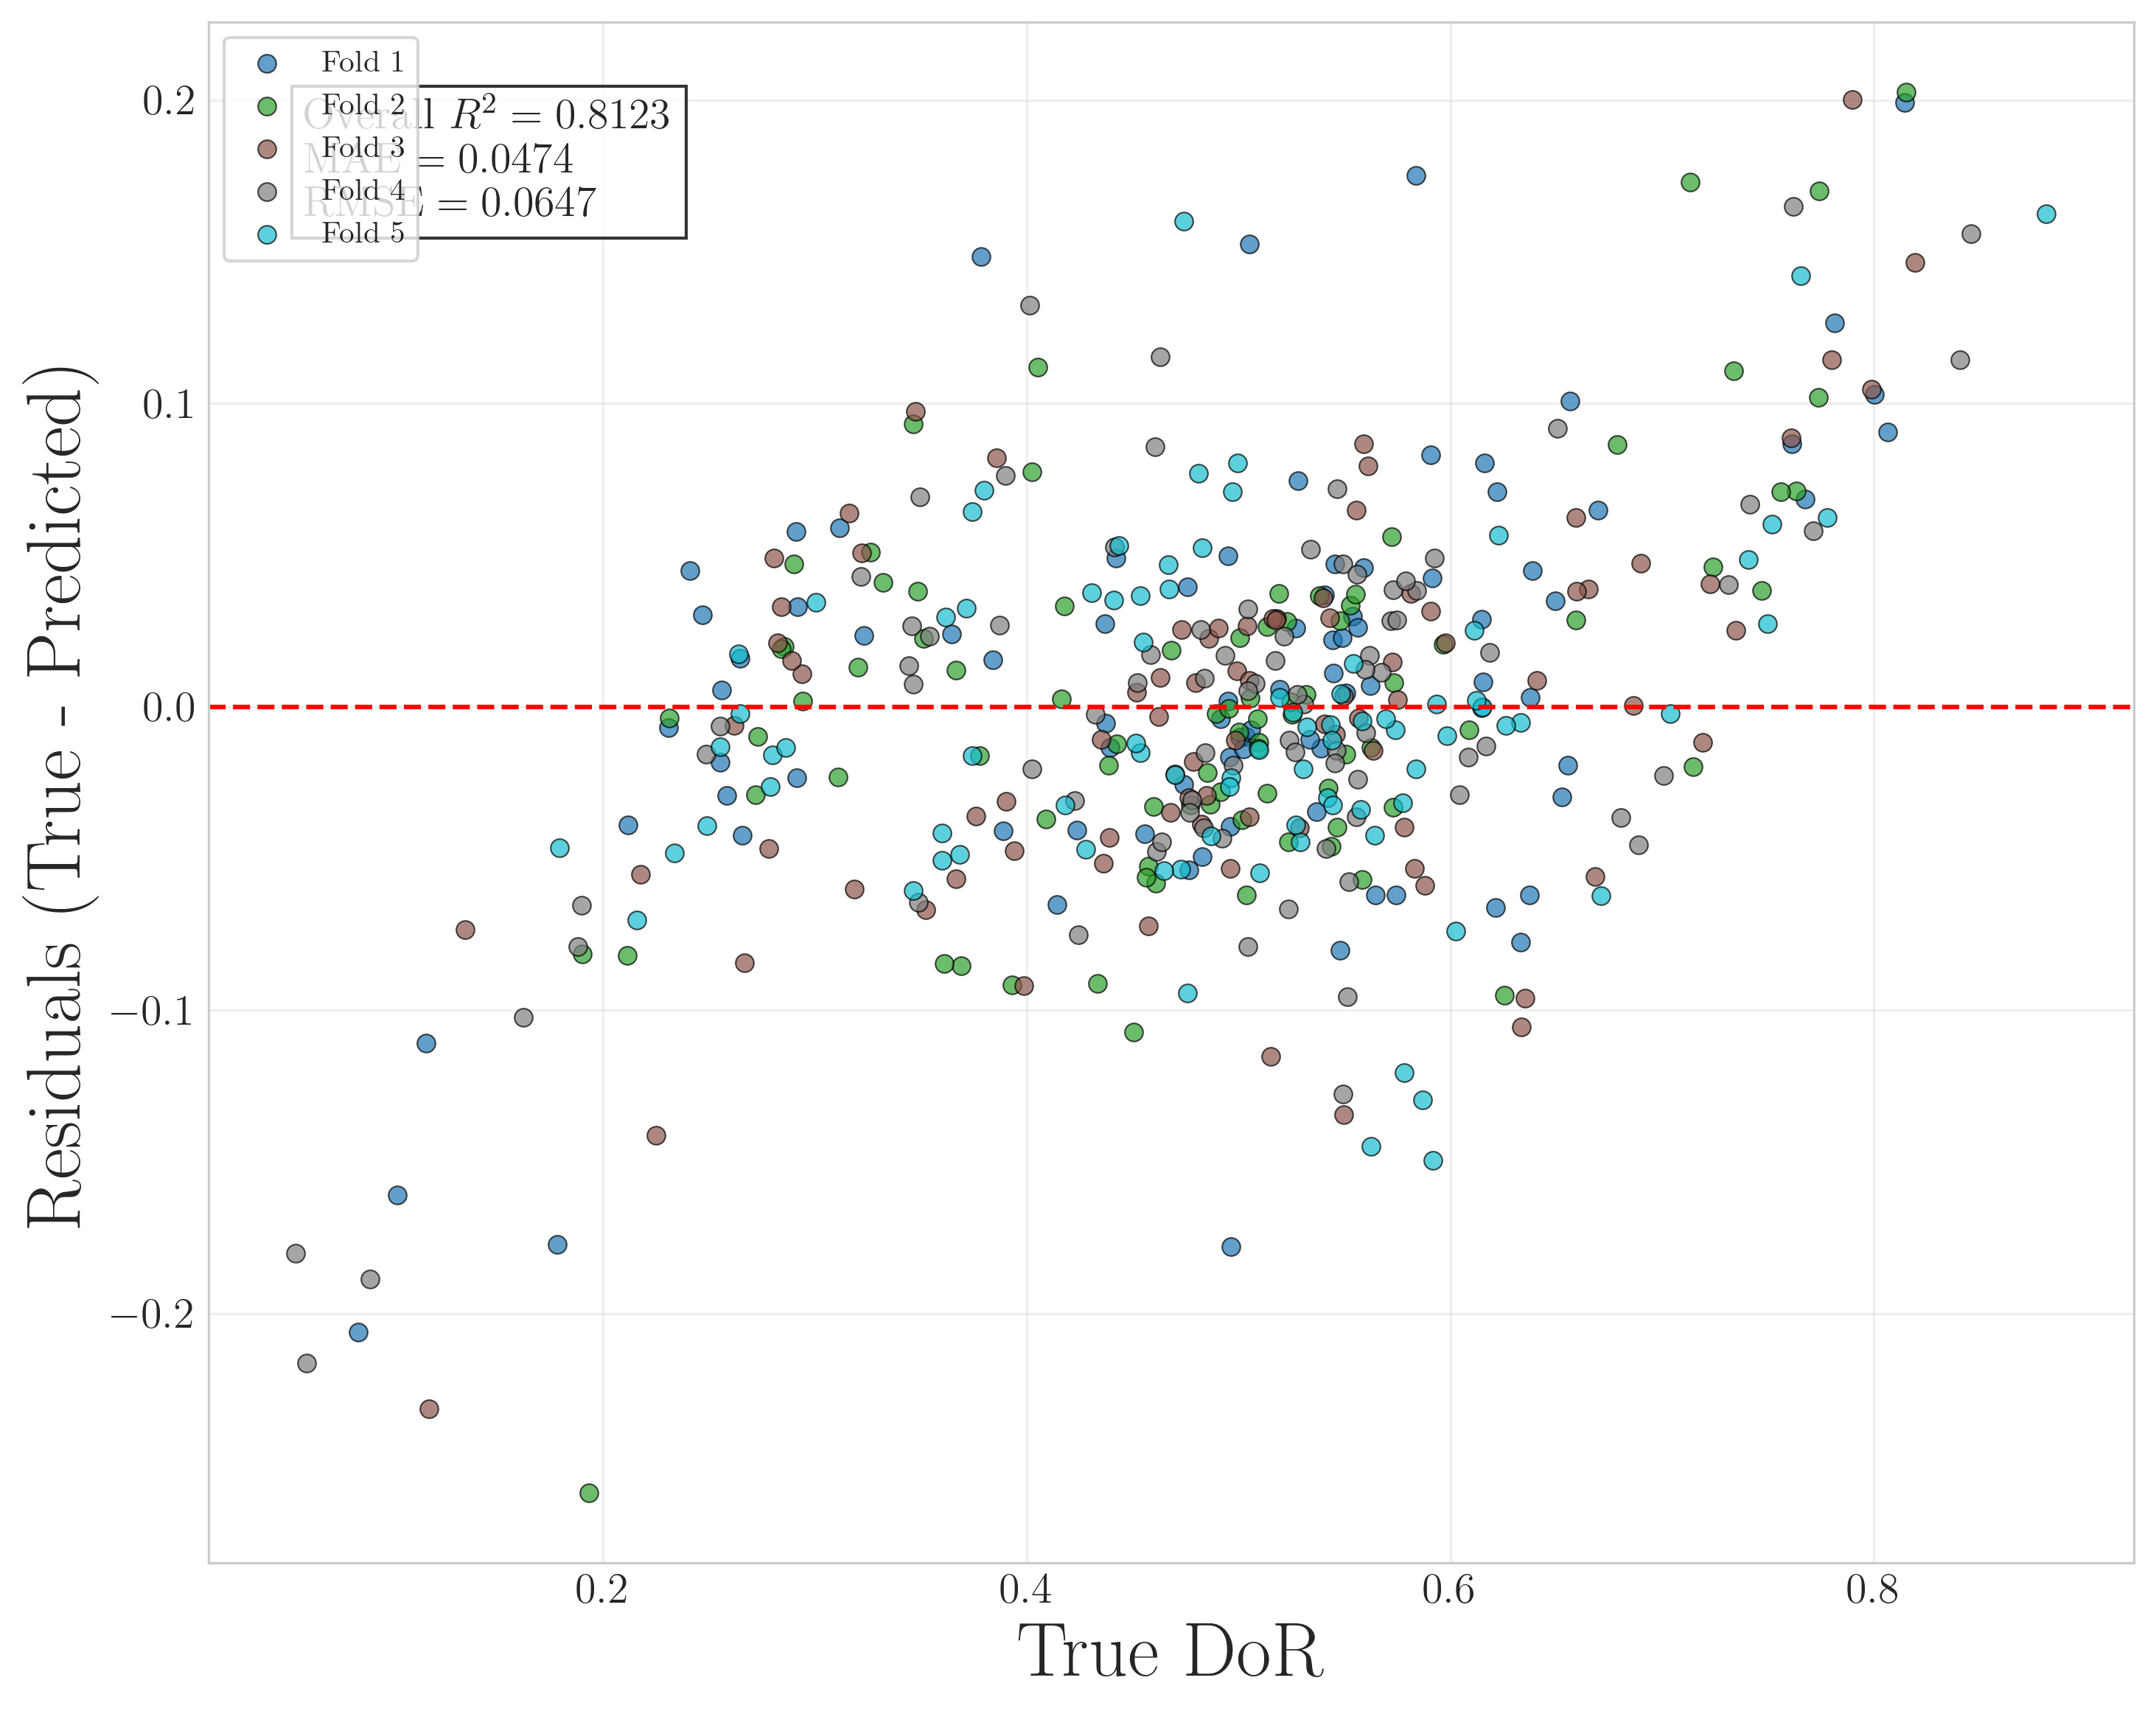

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def plot_residuals_vs_true(df, features, target='DoR', n_splits=5, model_params=None, output_path=None):
    """
    Creates a plot of residuals vs true values from K-fold cross-validation results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataset
    features : list
        List of feature column names
    target : str, default='DoR'
        Target variable column name
    n_splits : int, default=5
        Number of folds for cross-validation
    model_params : dict, optional
        Parameters for the RandomForestRegressor
    output_path : str, optional
        Path to save the output figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure
    fold_results : dict
        Dictionary containing the cross-validation results
    """
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Default model parameters if none provided
    if model_params is None:
        seed = 42  # Define a seed for reproducibility
        model_params = {
            'max_depth': 22,
            'max_features': 0.793,
            'max_samples': 0.500,
            'min_samples_leaf': 1,
            'min_samples_split': 4,
            'n_estimators': 460,
            'random_state': seed
        }
    else:
        seed = model_params.get('random_state', 42)
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initialize arrays to store all predictions and residuals
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    all_residuals = np.zeros_like(y)
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {'r2_scores': [], 'mae': [], 'rmse': [], 'indices': [], 'predictions': [], 'residuals': []}
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model and make predictions
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        
        # Calculate residuals (true - predicted)
        residuals = y_test - y_pred
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store results for this fold
        fold_results['r2_scores'].append(r2)
        fold_results['mae'].append(mae)
        fold_results['rmse'].append(rmse)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        fold_results['residuals'].append(residuals)
        
        # Store at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        all_residuals[test_idx] = residuals
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    # Calculate overall metrics
    overall_r2 = r2_score(all_true, all_pred)
    overall_mae = mean_absolute_error(all_true, all_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    
    print(f"\nOverall metrics:")
    print(f"R²: {overall_r2:.4f}, MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}")

    # Create figure for the residuals vs true values plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot residuals vs true values for each fold with different colors
    for fold in range(1, n_splits + 1):
        mask = fold_indices == fold
        ax.scatter(all_true[mask], all_residuals[mask], alpha=0.7, s=35, 
                  color=fold_colors[fold-1], edgecolors='k', linewidths=0.5,
                  label=f'Fold {fold}')
    
    ax.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    
    ax.set_xlabel(f'True {target}', fontsize=25)
    ax.set_ylabel('Residuals (True - Predicted)', fontsize=25)
    
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax.minorticks_on()
    
    # Add legend
    ax.legend(loc='upper left', fontsize=10)
    
    # Add overall metrics in a textbox
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    textstr = '\n'.join((
        r'$\mathrm{Overall}\ R^2 = %.4f$' % (overall_r2,),
        r'$\mathrm{MAE} = %.4f$' % (overall_mae,),
        r'$\mathrm{RMSE} = %.4f$' % (overall_rmse,)
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props, horizontalalignment='left')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
    
    return fig, fold_results

# Example usage:
fig, results = plot_residuals_vs_true(
     df,  
     features=FEATURES,
     target='DoR',
     n_splits=5,
     model_params=MODEL_PARAMS,
     output_path='../outputs/residuals_vs_true.pdf'
)

# Classification and other stuff


Running 5-fold classification...

Fold 1/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.91      0.95      0.93        66
   DoR > 0.6       0.82      0.70      0.76        20

    accuracy                           0.90        86
   macro avg       0.87      0.83      0.85        86
weighted avg       0.89      0.90      0.89        86


Fold 2/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.97      1.00      0.99        72
   DoR > 0.6       1.00      0.86      0.92        14

    accuracy                           0.98        86
   macro avg       0.99      0.93      0.95        86
weighted avg       0.98      0.98      0.98        86


Fold 3/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.97      0.93      0.95        69
   DoR > 0.6       0.75      0.88      0.81        17

    accuracy                           0.92        86
   macro avg       0.86      0.90      0.88        86
weighted a

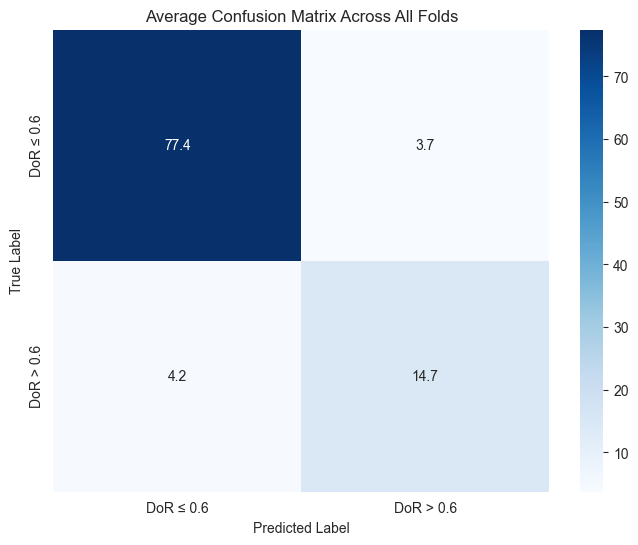

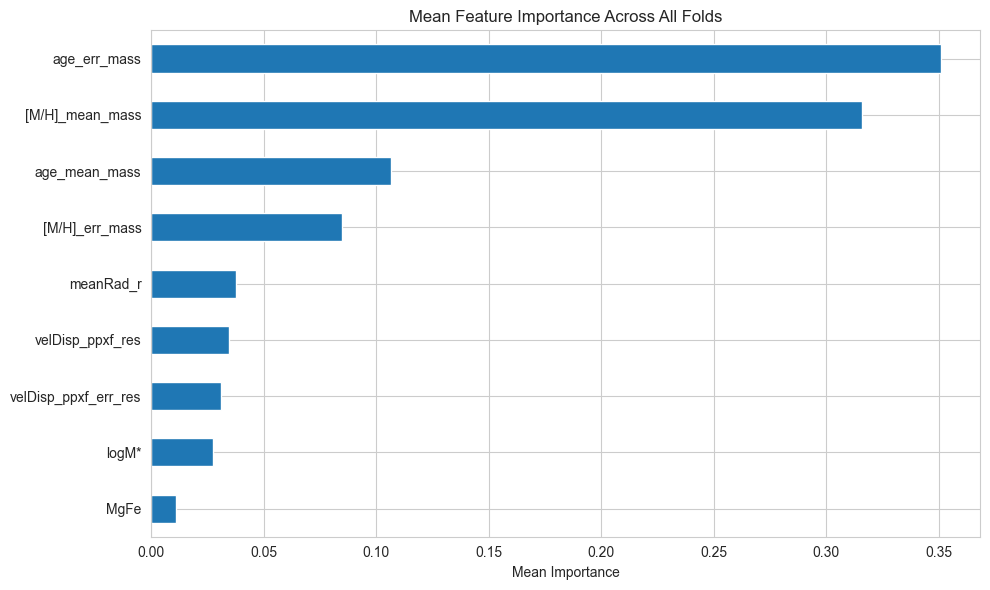

In [164]:
class_results = evaluate_classification(df, n_splits=5, split_threshold=0.6)


Checking that seed isnt important

In [165]:
"""seeds = [0,1,2,3,4,5,6,7,8,9]
r2 = []
seeds = np.arange(100)
print(seeds)

for seed in seeds:
    print("SEED", seed)
    rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df, seed=seed)
    r2.append(test_r2)
    

print(np.mean(r2), np.std(r2))"""

'seeds = [0,1,2,3,4,5,6,7,8,9]\nr2 = []\nseeds = np.arange(100)\nprint(seeds)\n\nfor seed in seeds:\n    print("SEED", seed)\n    rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df, seed=seed)\n    r2.append(test_r2)\n    \n\nprint(np.mean(r2), np.std(r2))'

## Checking random stuff that might be interesting ML wise. 

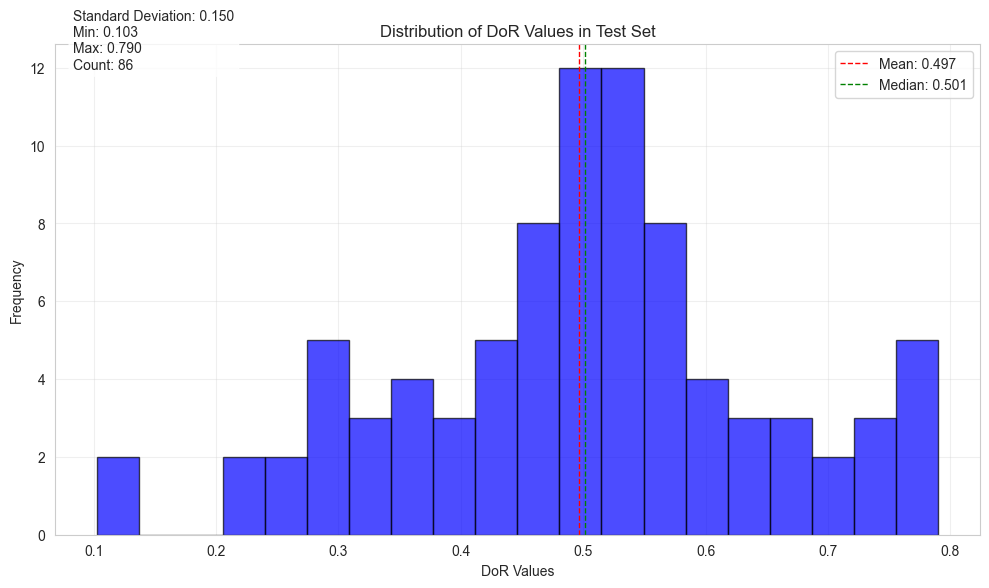

In [166]:
# Create histogram of DoR values in test set
def plot_dor_histogram(df, test_size=0.2):
    # Extract features and target
    X = df[FEATURES]
    y = df['DoR']
    
    # Split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    hist = plt.hist(y_test, bins=20, alpha=0.7, color='blue', edgecolor='black')
    
    # Add distribution statistics
    plt.axvline(y_test.mean(), color='red', linestyle='dashed', linewidth=1, 
                label=f'Mean: {y_test.mean():.3f}')
    plt.axvline(y_test.median(), color='green', linestyle='dashed', linewidth=1, 
                label=f'Median: {y_test.median():.3f}')
    
    # Add text with additional statistics
    stats_text = (f"Standard Deviation: {y_test.std():.3f}\n"
                  f"Min: {y_test.min():.3f}\n"
                  f"Max: {y_test.max():.3f}\n"
                  f"Count: {len(y_test)}")
    plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Formatting
    plt.xlabel('DoR Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of DoR Values in Test Set')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return y_test

# Usage example (you can uncomment this when ready to run)
test_dor_values = plot_dor_histogram(df, test_size=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegre

IndexError: index 4 is out of bounds for axis 0 with size 4

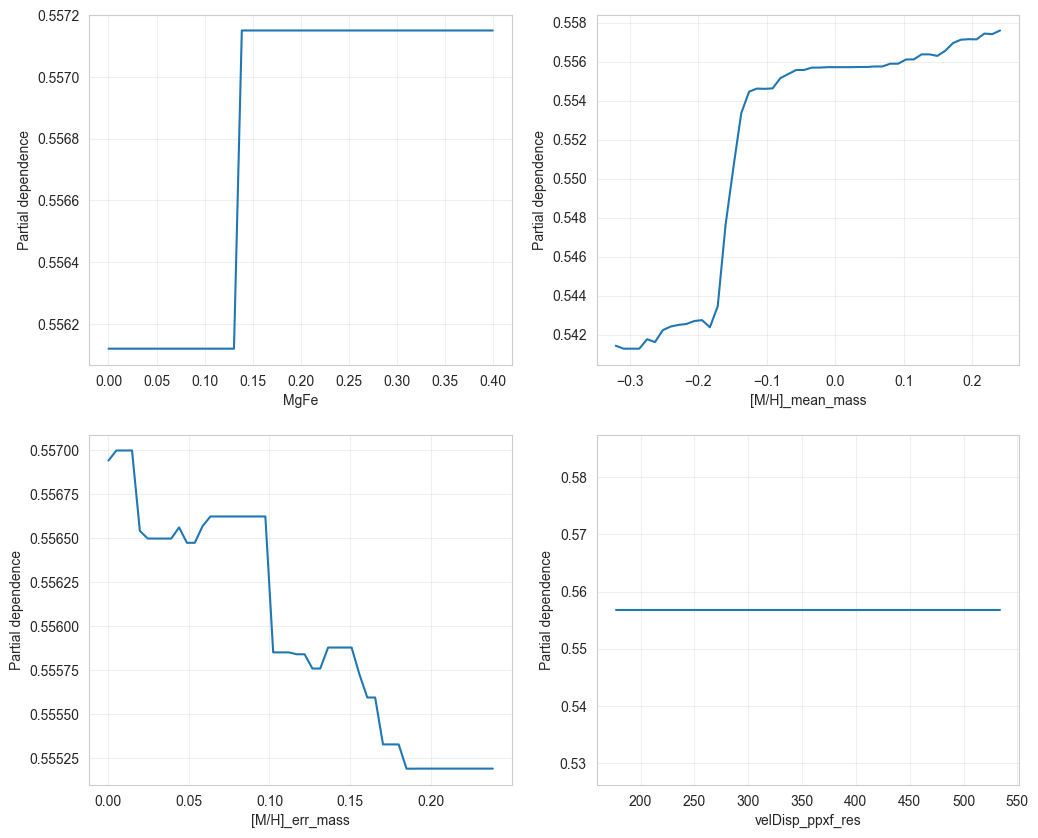

In [167]:
import numpy as np
from sklearn.inspection import partial_dependence

# Your features list
X = df[FEATURES]
y = df['DoR']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(FEATURES):
    # Get the feature index
    feature_idx = FEATURES.index(feature)
    
    # Calculate the partial dependence manually
    # Create a grid of values for the feature
    feature_values = np.linspace(
        X[feature].min(), 
        X[feature].max(),
        num=50
    )
    
    # For each value, create a copy of X and set the feature to that value
    predictions = []
    for val in feature_values:
        X_modified = X.copy()
        X_modified[feature] = val
        prediction = rf_model.predict(X_modified).mean()
        predictions.append(prediction)
    
    # Plot the results
    axes[i].plot(feature_values, predictions)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial dependence')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(FEATURES):
    PartialDependenceDisplay.from_estimator(
        rf_model, X, [feature], 
        kind='individual', centered=True, 
        ax=axes[i], n_jobs=-1
    )
    axes[i].set_ylabel('Effect on DoR prediction')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import shap
shap.initjs()

In [ ]:
features = FEATURES
# Create a SHAP explainer for your random forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# Summary plot showing feature importance and impact direction
shap.summary_plot(shap_values, X, feature_names=features)

# Detailed dependence plot for the most important feature
# (e.g., MgFe or velocity dispersion)
shap.dependence_plot("MgFe", shap_values, X, feature_names=features)

# Force plot for specific examples (e.g., a borderline relic)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], 
                feature_names=features)

In [ ]:
# 1. Use matplotlib-based visualizations instead
shap.summary_plot(shap_values, X, feature_names=features, plot_type="bar")  # Bar chart only

# 2. Try non-interactive versions
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, feature_names=features, show=False)
plt.tight_layout()
plt.show()

# 3. For dependence plots (still works without JS)
shap.dependence_plot("MgFe", shap_values, X, feature_names=features)